# Transformer-based Named Entity Recognition for Book Titles in Newspaper Archives

This notebook demonstrates the process of creating and training a Named Entity Recognition (NER) model to identify book titles in newspaper archives. The dataset includes articles from "Leeuwarde Courant" (often referred to as "LC"), "Parool", and "Trouw" newspapers.

The notebook covers the following steps:
1. **Data Preparation**: Loading and cleaning data from different sources, and preparing it for NER model training.
2. **Dataset Creation**: Creating datasets for training, validation, and testing, and saving them to disk.
3. **Model Training**: Setting up and training a transformer-based model for NER.
4. **Evaluation**: Evaluating the model's performance on test datasets.
5. **Visualization**: Visualizing the model's predictions on sample texts.

The goal is to develop a robust NER model that can accurately identify book titles in historical newspaper texts, facilitating further analysis and research on literary references in news archives.

Let's get started!

## Import necessary libraries

In [1]:
# !python -m spacy download nl_core_news_sm

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import string
import re

from datasets import Dataset, load_metric
from transformers import DataCollatorForTokenClassification, pipeline, AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, TrainerCallback

import torch

import spacy
from spacy import displacy

import os
from datetime import datetime
import json

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import pickle
import math

C:\Users\niels\miniconda3\envs\BookReviewsThesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the current notebook directory
current_dir = os.path.abspath('')

# Set the main directory (modify as needed to point to your main project directory)
main_dir = os.path.abspath(os.path.join(current_dir, '../'))

# Change the working directory to the main directory
os.chdir(main_dir)

# Verify that the working directory has been set correctly
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\niels\PycharmProjects\BookReviewsThesis


In [4]:
# Import custom functions from the dataset preparation module
from scripts.loss_functions import DiceLoss, MoMLoss
from scripts.dataset_preparation import remove_punctuation, find_sentence_in_text, create_mask_for_sentence, process_text, \
                                        create_data_set, trouw_parool_create_dataset, save_dataset, load_dataset, split_samples, remove_extra_spaces

## Data Preparation

In [5]:
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

In [6]:
# Load data from Excel and CSV files into DataFrames

# Load leeuwarde courant Excel file into a DataFrame
df_lc = pd.read_excel('data/raw/manullay_check_partially_matched_titles.xlsx', engine='openpyxl')

# Load Trouw and Het Parool annotated book review file into a DataFrame
df_trouw_parool = pd.read_csv('data/raw/trouw_and_parool_annotated_book_titles.csv')

In [8]:
# Apply the remove_extra_spaces function to relevant columns in df_lc
df_lc['content'] = df_lc['content'].apply(remove_extra_spaces)
df_lc['title1'] = df_lc['title1'].apply(remove_extra_spaces)
df_lc['title4'] = df_lc['title4'].apply(remove_extra_spaces)

In [9]:
# Filter out rows with 'manually_removed' set to 1 and get unique 'content' values
content_removed = df_lc[df_lc['manually_removed'] == 1]['content'].unique()

# Filter out the removed 'content' values from the main DataFrame
df_lc_clean = df_lc[~df_lc['content'].isin(content_removed)]

## Preprare for training

In [10]:
# Set the model checkpoint to be used for token classification

model_checkpoint = "Babelscape/wikineural-multilingual-ner"

# Alternative model checkpoints (commented out):
# model_checkpoint = "FacebookAI/xlm-roberta-large-finetuned-conll03-english"
# model_checkpoint = "pdelobelle/robbert-v2-dutch-ner"
# model_checkpoint = "GroNLP/bert-base-dutch-cased"

In [11]:
# Define the list of labels for NER tagging
label_list = ['O', 'I']

In [12]:
# Load the spaCy model for Dutch language processing
nlp = spacy.load("nl_core_news_sm")

In [13]:
# Set flags for punctuation removal and case conversion
remove_punc = False
force_lower_case = False

In [14]:
# Define file paths for saving/loading datasets
lc_train_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_train_dataset.pkl'
lc_val_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_val_dataset.pkl'
lc_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/lc_test_dataset.pkl'

trouw_parool_test_filename = 'C:/Users/niels/PycharmProjects/BookReviewsThesis/data/processed/trouw_parool_test_dataset.pkl'

In [15]:
# Split the samples into training, validation, and test sets

# Set the random seed for reproducibility
np.random.seed(42)

# Get unique content samples
samples = df_lc_clean['content'].unique()

# Split the samples into training, validation, and test sets
lc_train_samples, lc_val_samples, lc_test_samples = split_samples(samples=samples, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

# Check if datasets already exist, otherwise create them
if os.path.exists(lc_train_filename) and os.path.exists(lc_val_filename) and os.path.exists(lc_test_filename):
    print("Loading training, validation, and test datasets....")
    lc_train_dataset = load_dataset(lc_train_filename)
    lc_val_dataset = load_dataset(lc_val_filename)
    lc_test_dataset = load_dataset(lc_test_filename)
else:
    print("Creating training, validation, and test datasets....")
    # Create dataset
    lc_train_dataset = Dataset.from_list(create_data_set(samples=lc_train_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_val_dataset = Dataset.from_list(create_data_set(samples=lc_val_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    lc_test_dataset = Dataset.from_list(create_data_set(samples=lc_test_samples, df=df_lc_clean, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))

    # Save dataset, so we don't have to create it everytime again
    save_dataset(lc_train_dataset, lc_train_filename)
    save_dataset(lc_val_dataset, lc_val_filename)
    save_dataset(lc_test_dataset, lc_test_filename)

print("Done...")

Loading training, validation, and test datasets....
Done...


In [16]:
# Display the leeuwarde Courant train dataset
lc_train_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 8774
})

In [17]:
# Display the leeuwarde Courant validation dataset
lc_val_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1880
})

In [18]:
# Display the leeuwarde Courant test dataset
lc_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 1881
})

### Create Trouw & Parool TEST dataset

In [19]:
# Create or load the Trouw/Parool test dataset

if os.path.exists(trouw_parool_test_filename):
    print("Loading trouw parool test dataset....")
    trouw_parool_test_dataset = load_dataset(trouw_parool_test_filename)
else:
    print("Creating trouw parool test dataset....")
    trouw_parool_test_dataset = Dataset.from_list(trouw_parool_create_dataset(df=df_trouw_parool, nlp=nlp, remove_punc=remove_punc, force_lower_case=force_lower_case))
    
    # Save dataset, so we don't have to create it everytime again
    save_dataset(trouw_parool_test_dataset, trouw_parool_test_filename)

Loading trouw parool test dataset....


In [20]:
# Display the Trouw/Parool test dataset
trouw_parool_test_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 308
})

## Tokenize text representation and align subtokens with labels

In [21]:
# Load the tokenizer from the specified model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# from transformers import RobertaTokenizerFast

# # Instantiate the tokenizer with add_prefix_space=True
# tokenizer = RobertaTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True, truncation=True, max_length=512, padding='max_length')

In [22]:
# Define function to tokenize inputs and align labels

label_all_tokens = True

def tokenize_and_align_labels(examples):
    """
    Tokenize inputs and align labels for token classification.

    Args:
        examples (dict): A dictionary containing the tokens and NER tags.

    Returns:
        dict: A dictionary with tokenized inputs and aligned labels.
    """
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels

    return tokenized_inputs

In [23]:
# Tokenize the datasets and align the labels
lc_tokenized_dataset_train = lc_train_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_val = lc_val_dataset.map(tokenize_and_align_labels, batched=True)
lc_tokenized_dataset_test = lc_test_dataset.map(tokenize_and_align_labels, batched=True)

trouw_parool_tokenized_dataset_test = trouw_parool_test_dataset.map(tokenize_and_align_labels, batched=True)

# Display the tokenized training dataset
lc_tokenized_dataset_train

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 467.46 examples/s]


Dataset({
    features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 8774
})

In [24]:
# Define function to compute evaluation metrics
def compute_metrics(p): 
    """
    Compute evaluation metrics for model predictions.

    Args:
        p (tuple): A tuple containing logits and labels.

    Returns:
        dict: A dictionary with evaluation metrics (F1 score, recall, precision, accuracy).
    """
    
    logits, labels = p
    predictions = np.argmax(logits, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)
    ]

    total_count_O = 0
    total_count_I = 0
    for pred in true_predictions:
        total_count_O = total_count_O + sum(s.count("O") for s in pred)
        total_count_I = total_count_I + sum(s.count("I") for s in pred)
        
    # Flatten the lists to enable F1 calculation using sklearn
    flat_predictions = [label for sublist in true_predictions for label in sublist]
    flat_labels = [label for sublist in true_labels for label in sublist]

    # Calculate the F1 score
    f1 = f1_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    recall = recall_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    precision = precision_score(y_true=flat_labels, y_pred=flat_predictions, average='binary', pos_label='I')
    accuracy = accuracy_score(y_true=flat_labels, y_pred=flat_predictions)

    
    return {
        "total_count_O": total_count_O,
        "total_count_I": total_count_I,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "accuracy": accuracy
    }

In [25]:
# Set the device to use for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Initialize data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [27]:
# Load the pre-trained model for token classification
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint, num_labels=2, ignore_mismatched_sizes=True
)
model.config.id2label = {0: 'NO_BOOK', 1: 'BOOK'}

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Babelscape/wikineural-multilingual-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Get the number of parameters in the model
num_parameters = model.num_parameters()
print(f"Number of parameters in the model: {num_parameters}")

Number of parameters in the model: 177264386


In [29]:
# Define a custom trainer class for training the model with a specialized loss function

class MyTrainer(Trainer):
    """
    A custom trainer class that extends the Trainer class to provide specialized loss computation
    and enhanced logging capabilities specific to the model's training process.

    This trainer overrides the compute_loss method to utilize a custom loss function, referred to here
    as MoMLoss, which is applied to the logits produced by the model. Additionally, this class modifies
    the logging functionality to record the loss at each training step along with its corresponding epoch,
    facilitating detailed tracking and analysis of the model's training progression.

    Attributes:
        loss_history (list of dict): Keeps a record of loss values and their corresponding epoch numbers.
                                     This enables easy tracking and visualization of the training loss over time.

    Methods:
        compute_loss(model, inputs, return_outputs=False): Computes the loss using MoMLoss based on the outputs
                                                           from the model and the provided labels. It can optionally
                                                           return the model outputs alongside the loss.

        log(logs): Extends the base Trainer's log method to also append the loss and epoch to the loss_history for
                   historical tracking. This is particularly useful for visualizing the training progression post-training.

    Example:
        class MyModel(nn.Module):
            # model definition

        trainer = MyTrainer(MyModel(), other_args)
        trainer.train()
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
    
    def compute_loss(self, model, inputs, return_outputs=False):
        """ MoM LOSS """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits  # Assuming logits are stored in outputs.logits

        # Compute loss using DiceLoss
        loss_fn = MoMLoss()
        loss = loss_fn(logits, labels)

        # Store loss for logging
        self.log({"loss": loss.item(), "epoch": self.state.epoch})

        return (loss, outputs) if return_outputs else loss

    def log(self, logs):
        super().log(logs)
        # Save the training loss for each log step
        if self.model.training:
            if 'loss' in logs:
                self.loss_history.append({"epoch": logs.get("epoch", 0), "loss": logs["loss"]})

In [30]:
# Define function to visualize training history

def visualise_training_history(trainer):
    """
    Generates a plot showing smoothed training loss, training F1 score, and evaluation F1 score over epochs. 
    The training loss is smoothed to take an average over an epoch, as the training loss is calculated for each batch indiviually per epoch (thus multiple times per epoch).

    Args:
        trainer: A training instance containing loss_history and state.log_history.
        window_size: The size of the moving average window for smoothing the loss.

    Returns:
        fig: A matplotlib figure object with the plot.
    """
    epoch_losses = {}
    for point in trainer.loss_history:
        # Use ceiling to round the epoch to the next highest whole number
        epoch = math.ceil(point['epoch'])
        loss = point['loss']
        if epoch not in epoch_losses:
            epoch_losses[epoch] = []
        epoch_losses[epoch].append(loss)
    
    # Calculate average loss per epoch
    epochs = sorted(epoch_losses.keys())
    avg_losses = [np.mean(epoch_losses[epoch]) for epoch in epochs]
    
    eval_epochs = [math.ceil(entry['epoch']) for entry in trainer.state.log_history if 'eval_f1' in entry]
    eval_f1_scores = [entry['eval_f1'] for entry in trainer.state.log_history if 'eval_f1' in entry]

    # Create the plot for smoothed training loss
    fig, ax1 = plt.subplots(figsize=(10, 6))
    line1, = ax1.plot(epochs, avg_losses, marker='o', color='b', label='Training Loss (MoM)')
    ax1.set_title("Training Loss and Evaludation F1 Score vs. Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss")
    ax1.grid(True)
    
    # Create secondary y-axis for F1 scores
    ax2 = ax1.twinx()
    line2, = ax2.plot(eval_epochs, eval_f1_scores, marker='s', color='r', label='Evaluation F1 Score')
    ax2.set_ylabel('F1 Score')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    return fig

## Training

In [31]:
# Set up training arguments and create a custom trainer instance
training_args = TrainingArguments(
    output_dir= r"D:\test_model",
    learning_rate=2.5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=True,  # Enable mixed precision training (trains faster and decreases gpu memory)
    dataloader_pin_memory=True,  # Pin memory in dataloader (trains faster and decreases gpu memory)
    push_to_hub=False
)

# Create a custom Trainer instance
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=lc_tokenized_dataset_train,
    eval_dataset=lc_tokenized_dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [32]:
# Clear up RAM space by deleting large DataFrames
del df_lc
del lc_train_dataset
del lc_val_dataset

In [33]:
# Train the model using the custom trainer
# NOTE: Due to custom loss and trainer objects is the default Loss visualization output incorrect, the training history figure below is the correct reference
trainer.train()

Epoch,Training Loss,Validation Loss,Total Count O,Total Count I,F1,Recall,Precision,Accuracy
1,0.177661,0.306517,815967,53630,0.520701,0.941552,0.359855,0.959143
2,0.129376,0.297912,824861,44736,0.583171,0.927989,0.425183,0.968731
3,0.139470,0.415482,838297,31300,0.705832,0.891838,0.584026,0.982478
4,0.151559,0.464665,835529,34068,0.680583,0.905889,0.545028,0.979957
5,0.061817,0.463103,839292,30305,0.727570,0.901644,0.609833,0.984085
6,0.191785,0.594548,842859,26738,0.760961,0.876811,0.672152,0.987016
7,0.492274,0.895706,844572,25025,0.770660,0.855784,0.700939,0.987994
8,0.044156,0.773470,843010,26587,0.761745,0.874909,0.674503,0.987100
9,0.557726,0.910669,844928,24669,0.780631,0.860077,0.714622,0.988606
10,0.515861,1.169060,846690,22907,0.789190,0.835586,0.747675,0.989478


TrainOutput(global_step=10980, training_loss=0.06989013640606989, metrics={'train_runtime': 7436.2105, 'train_samples_per_second': 23.598, 'train_steps_per_second': 1.477, 'total_flos': 4.585235487203328e+16, 'train_loss': 0.06989013640606989, 'epoch': 20.0})

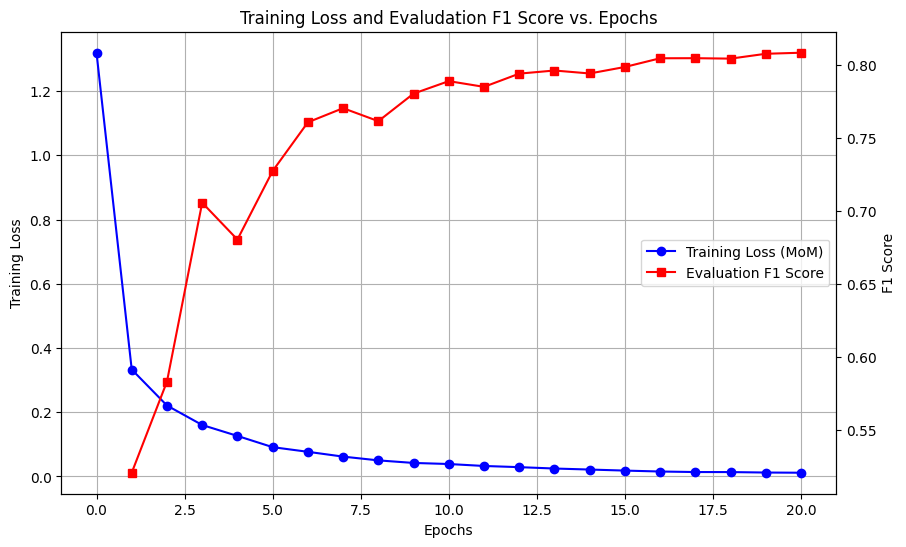

In [34]:
# Visualize the training history
fig = visualise_training_history(trainer)

## Evaluate models on test datasets

In [35]:
# Move the model to the specified device (GPU/CPU)
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [36]:
# Evaluate the model on the leeuwarde courant validation dataset
trainer.evaluate(lc_tokenized_dataset_val)

{'eval_loss': 1.4749563932418823,
 'eval_total_count_O': 848166,
 'eval_total_count_I': 21431,
 'eval_f1': 0.8086720091585575,
 'eval_recall': 0.8270966482899936,
 'eval_precision': 0.7910503476272689,
 'eval_accuracy': 0.9907750371723913,
 'eval_runtime': 37.9677,
 'eval_samples_per_second': 49.516,
 'eval_steps_per_second': 3.108,
 'epoch': 20.0}

In [37]:
# Evaluate the model on the leeuwarde courant test dataset
trainer.evaluate(lc_tokenized_dataset_test)

{'eval_loss': 1.3552734851837158,
 'eval_total_count_O': 844085,
 'eval_total_count_I': 21368,
 'eval_f1': 0.8133872782552488,
 'eval_recall': 0.8326226535313435,
 'eval_precision': 0.7950205915387495,
 'eval_accuracy': 0.9909931561852579,
 'eval_runtime': 35.8792,
 'eval_samples_per_second': 52.426,
 'eval_steps_per_second': 3.289,
 'epoch': 20.0}

In [38]:
# Evaluate the model on the Trouw/Parool test dataset
trainer.evaluate(eval_dataset=trouw_parool_tokenized_dataset_test)

{'eval_loss': 5.419482707977295,
 'eval_total_count_O': 147344,
 'eval_total_count_I': 2454,
 'eval_f1': 0.5411436541143654,
 'eval_recall': 0.436609152288072,
 'eval_precision': 0.7114914425427873,
 'eval_accuracy': 0.9802333809530167,
 'eval_runtime': 6.3308,
 'eval_samples_per_second': 48.651,
 'eval_steps_per_second': 3.159,
 'epoch': 20.0}

### Export model, training history, tokenizer & history

In [39]:
# Define the export path for saving the trained model
export_path = f"C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/{datetime.now().strftime('%Y-%m-%d_%H_%M')}/"
export_path

'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/'

In [40]:
# Create the export directory if it does not exist
os.makedirs(export_path, exist_ok=True)

In [41]:
# Save the trained model and tokenizer to the export path
trainer.save_model(export_path + "model")
tokenizer.save_pretrained(export_path + "tokenizer")

('C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/tokenizer\\tokenizer_config.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/tokenizer\\special_tokens_map.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/tokenizer\\vocab.txt',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/tokenizer\\added_tokens.json',
 'C:/Users/niels/PycharmProjects/BookReviewsThesis/models/transformer/2024-06-06_10_22/tokenizer\\tokenizer.json')

In [42]:
# Save the training history and model details to JSON files
with open(export_path + "history.json", 'w') as file:
    json.dump(trainer.state.log_history, file, indent=4)
with open(export_path + "loss_training_history.json", 'w') as file:
    json.dump(trainer.loss_history, file, indent=4)
with open(export_path + "model_name.txt", 'w') as file:
    file.write(model_checkpoint)  # Writing the string to the file

In [43]:
# Save the training history plot to a PNG file
fig.savefig(export_path + "training_and_f1_plot.png")

## Visualization of predictions on unseen data

In [44]:
# Define functions to merge overlapping intervals and visualize NER output

def merge_overlapping_intervals(intervals):
    """
    Merge overlapping intervals in a list of intervals.

    Args:
        intervals (list of tuple): List of intervals (start, end, label).

    Returns:
        list of tuple: List of merged intervals.
    """
    merged_intervals = []
    if not intervals:
        return merged_intervals

    # Sort intervals based on the start value
    intervals.sort(key=lambda x: x[0])

    # Initialize variables for the first interval
    start, end, label = intervals[0]

    # Iterate through the intervals
    for interval in intervals[1:]:
        next_start, next_end, next_label = interval

        # If the intervals overlap, merge them
        if next_start <= end + 1:
            end = max(end, next_end)
        else:
            # If no overlap, add the merged interval to the result and update start, end, label
            merged_intervals.append((start, end, label))
            start, end, label = next_start, next_end, next_label

    # Add the last merged interval
    merged_intervals.append((start, end, "BOOK"))

    return merged_intervals

def visualize_output(output, text, export_path=None):
    """
    Visualize NER output using spaCy's displaCy.

    Args:
        output (list): List of dictionaries containing NER predictions.
        text (str): The input text.
        export_path (str, optional): Path to save the visualization as an HTML file.

    Returns:
        None
    """
    spans = [(res['start'], res['end'], res['entity']) for res in output if res['entity'] == 'BOOK']
    spans = merge_overlapping_intervals(spans)

    nlp = spacy.blank('nl')
    doc = nlp.make_doc(text)
    ents = []
    for span_start, span_end, label in spans:
        ent = doc.char_span(span_start, span_end, label=label)
        if ent is None:
            continue
    
        ents.append(ent)
    
    doc.ents = ents
    
    if export_path:
        html = displacy.render(doc, style="ent", jupyter=False, page=True)
        # Save the HTML to a file
        with open(export_path, "w", encoding="utf-8") as file:
            file.write(html)
    else:
        displacy.render(doc, style="ent", jupyter=True)

In [45]:
# Initialize the pipeline for token classification
pipe = pipeline(task="token-classification", model=model, tokenizer=tokenizer)

### Leeuwarde Courant

In [46]:
# Set the index for visualizing a sample from the test set
visualize_index = 1

In [47]:
# Get a sample from the Leeuwarde Courant test set for visualization
lc_sample = lc_test_samples[visualize_index]

In [48]:
# Get NER predictions for the sample using the pipeline
output = pipe(lc_sample)

In [49]:
# Display the corresponding book titles in the sample from df_lc_clean
df_lc_clean[df_lc_clean['content'] == lc_sample].title4

6064    ontsporingen
Name: title4, dtype: object

In [50]:
# Visualize the NER output for the sample
visualize_output(output, lc_sample)

### Het Parool

In [51]:
# Filter Trouw/Parool data for the Parool newspaper
df_parool = df_trouw_parool[df_trouw_parool['newspaper'] == 'Parool']

In [52]:
# Get a sample text from the Parool data
parool_sample = df_parool.text.unique()[0]

In [53]:
# Get NER predictions for the Parool sample using the pipeline
output = pipe(parool_sample)

In [54]:
# Display the corresponding book titles in the Parool sample from df_parool
df_parool[df_parool['text'] == parool_sample].book_title

178    'Een beeld van de hemel.
179          'Blik op oneindig'
180            BUK OP ONEINDIG,
181    EEN BEELD VAN DE HEMELL.
Name: book_title, dtype: object

In [55]:
# Visualize the NER output for the Parool sample
visualize_output(output, parool_sample)

In [56]:
# Export example of output
visualize_output(output, parool_sample, export_path="ner_visualization.html")

### Trouw

In [57]:
# Filter Trouw/Parool data for the Trouw newspaper
df_trouw = df_trouw_parool[df_trouw_parool['newspaper'] == 'Trouw']

In [58]:
# Get a sample text from the Trouw data
trouw_sample = df_trouw.text.unique()[3]

In [59]:
# Get NER predictions for the Trouw sample using the pipeline
output = pipe(trouw_sample)

In [60]:
# Display the corresponding book titles in the Trouw sample from df_trouw
df_trouw[df_trouw['text'] == trouw_sample].book_title

6               Nederlandse Cultuur in de Gouden Eeuw,
7    The Embarrassment of riches, an interpretation...
Name: book_title, dtype: object

In [61]:
# Visualize the NER output for the Trouw sample
visualize_output(output, trouw_sample)

## Example how to Load model and tokenizer, and use it to make predictions:

In [62]:
model_new = AutoModelForTokenClassification.from_pretrained(export_path + "model")
tokenizer_new = AutoTokenizer.from_pretrained(export_path + "tokenizer")

In [63]:
pipe = pipeline(task="token-classification", model=model_new, tokenizer=tokenizer_new)

In [64]:
sentence = remove_punctuation(df_lc_clean['content'].unique()[0])

In [65]:
output = pipe(sentence)

In [66]:
visualize_output(output, sentence)